# Imbalanced take on wine quality classification problem

Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests . More on the dataset [here](https://archive.ics.uci.edu/ml/datasets/wine+quality).

The objective here is to predict the wine quality based on it's properties. 

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
from pandas.plotting import scatter_matrix

import seaborn as sns
sns.set()

In [4]:
path_data = Path("../data")
path_red = path_data / "winequality-red.csv"
path_white = path_data / "winequality-white.csv"

In [5]:
df_red = pd.read_csv(path_red, sep=';')
df_white= pd.read_csv(path_white, sep=';')

## Red wine classification

### Explore data 

In [6]:
df_red.shape

(1599, 12)

In [7]:
df_red['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [8]:
df_red.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [10]:
df_white.shape

(4898, 12)

In [12]:
df_white.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [15]:
df_master = pd.concat([df_white.assign(white=1), df_red.assign(red=1)]).fillna(0)

In [17]:
df_master['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

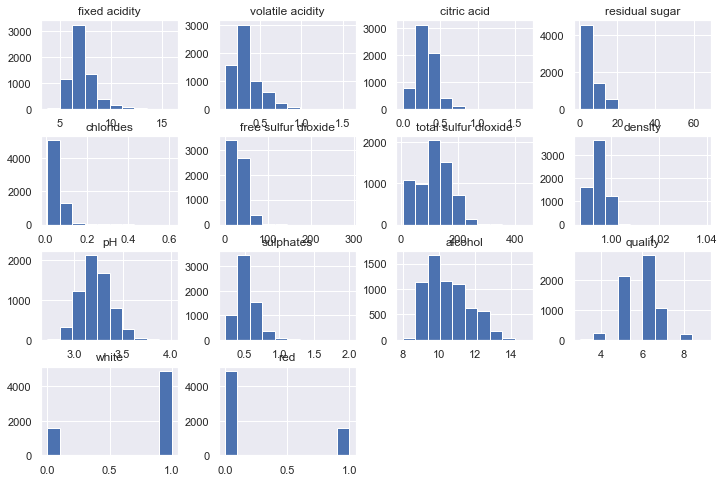

In [18]:
df_master.hist(figsize=(12,8));

### Transform data 

In [8]:
df_red['quality'] = np.where(df_red['quality'] > 6, 1,0)

In [9]:
df_red['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

In [10]:
color_dict = {
    0: 'blue',
    1: 'red'
}
col_map = df_red['quality'].map(color_dict).values

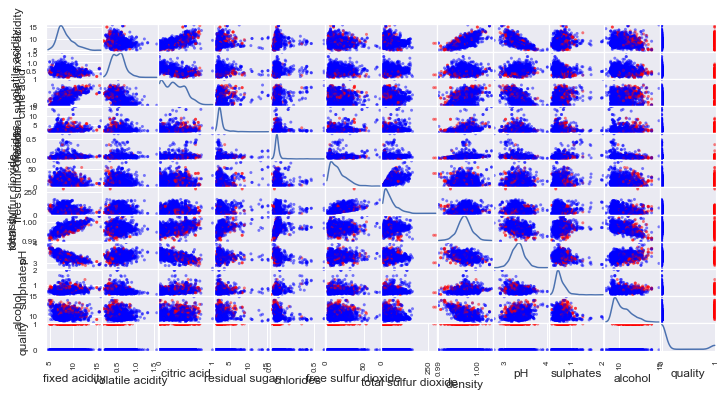

In [11]:
scatter_matrix(df_red, diagonal='kde', color=col_map, figsize= (12,6));

### Metric selection

We will predict class labels weather a wine is good above 7 quality or not below. 
Precision and recall are a good metric to start. We want to maximise recall as detection of a good wine is the objective. The F2-measure is selected.

### Dummy classifier 

In [12]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from collections import Counter
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split

def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

X, y = df_red.iloc[:, :-1].values, df_red.iloc[:, -1].values
print(X.shape, y.shape, Counter(y))
model = DummyClassifier(strategy='constant', constant=1)
metric = make_scorer(f2_measure)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
print("Mean f2: %.3f +/- (%.3f)" % (np.mean(scores), np.std(scores)))

(1599, 11) (1599,) Counter({0: 1382, 1: 217})
Mean f2: 0.440 +/- (0.006)


The average of the F2-measure scores is reported.  In this case, we can see that the baseline algorithm achieves an F2-measure of about 0.440.  This score provides a lower limit on model skill; any model that achieves an average F2-measure above about 0.440 has skill, whereas models that achieve a score below this value do not have skill on this dataset.

### Models review generic 

LR f2_score 0.284 +/- (0.082)
LDA f2_score 0.400 +/- (0.093)
GNB f2_score 0.576 +/- (0.111)
SVM f2_score 0.010 +/- (0.026)
GPC f2_score 0.465 +/- (0.115)


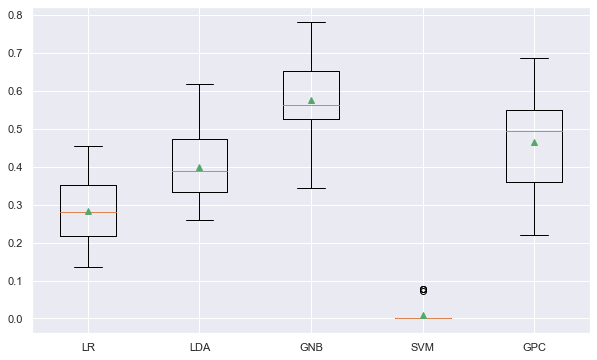

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from matplotlib import pyplot

def get_models():
    models = {}
    models['LR'] = LogisticRegression(solver='liblinear')
    models['LDA'] = LinearDiscriminantAnalysis()
    models['GNB'] = GaussianNB()
    models['SVM'] = SVC(gamma='scale')
    models['GPC'] = GaussianProcessClassifier()
    return models

# stratify y
X_train, X_test, y_train, y_test =  train_test_split(X, y, stratify=y)

results = {}
for name, model in get_models().items():
    cv =  RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
    print("%s f2_score %.3f +/- (%.3f)" % (name, np.mean(scores), np.std(scores)))
    results[name] = scores
    
pyplot.figure(figsize=(10,6));
pyplot.boxplot(x= results.values(), labels=results.keys(),
               showmeans=True);

As GNB and GPC assume Gaussian inputs and are preforming above the Dummy classifier will perform a power transform to all variables to a Gaussian distribution. 

### Model Review transform 

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer


results = {}
for name, model in get_models().items():
    cv =  RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    steps = [
    ('p', PowerTransformer()),
    ('m', model)
    ]
    pipeline = Pipeline(steps = steps)
    scores = cross_val_score(pipeline, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
    print("%s f2_score %.3f +/- (%.3f)" % (name, np.mean(scores), np.std(scores)))
    results[name] = scores



LR f2_score 0.383 +/- (0.092)
LDA f2_score 0.469 +/- (0.114)
GNB f2_score 0.622 +/- (0.125)
SVM f2_score 0.324 +/- (0.088)
GPC f2_score 0.483 +/- (0.110)


Not a real improvement overall. Next strategy will be to test come balanced cost - sensitive model to data to verify if any improvement is made.

### Model review cost-sensitive 

In [38]:
from sklearn.tree import DecisionTreeClassifier

def get_models():
    models = {}
    models['LR'] = LogisticRegression(solver='liblinear', class_weight='balanced')
    models['GNB'] = GaussianNB()
    models['SVM'] = SVC(gamma='scale', class_weight='balanced')
    models['GPC'] = GaussianProcessClassifier()
    models['DT'] = DecisionTreeClassifier(class_weight='balanced')
    return models

results = {}
for name, model in get_models().items():
    cv =  RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    steps = [
    ('p', PowerTransformer()),
    ('m', model)
    ]
    pipeline = Pipeline(steps = steps)
    scores = cross_val_score(pipeline, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
    print("%s f2_score %.3f +/- (%.3f)" % (name, np.mean(scores), np.std(scores)))
    results[name] = scores


LR f2_score 0.649 +/- (0.079)
GNB f2_score 0.622 +/- (0.125)
SVM f2_score 0.685 +/- (0.092)
GPC f2_score 0.483 +/- (0.110)
DT f2_score 0.583 +/- (0.109)


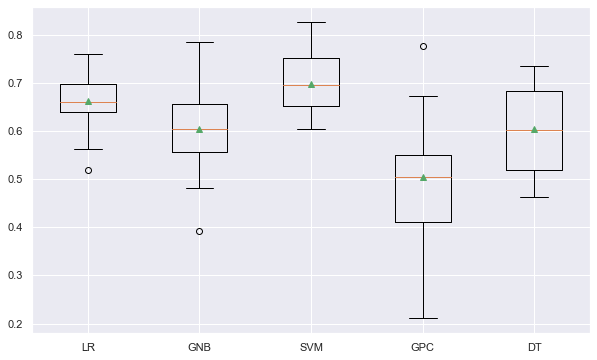

In [16]:
pyplot.figure(figsize=(10,6));
pyplot.boxplot(x= results.values(), labels=results.keys(),
               showmeans=True);

Significant boost in scores here. LR and SVM at around .66 and .69. Cost sensitive learning migth be a good route here. 
Other approaches to review : Ensemble RF with class weighting. 

### Data sampling methods

In [39]:
# Smote and Tomek links
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

def get_models():
    models = {}
    models['LR'] = LogisticRegression(solver='liblinear', class_weight='balanced')
    models['SVM'] = SVC(gamma='scale', class_weight='balanced')
    models['DT'] = DecisionTreeClassifier(class_weight='balanced')
    return models

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
results = {}

for name, model in get_models().items():
    
    pipeline = Pipeline(steps=[ 
                      ('t', PowerTransformer()),
                      ('r', resample),
                      ('m', model)
    ])
    results[name] = cross_val_score(pipeline, X_train, y_train, scoring = metric, cv=cv, n_jobs=-1)
    print("Model %s -> Mean F2 score %.3f +/- (%.3f)" % (name, np.mean(results[name]),
                                                        np.std(results[name])
                                                        )
         )

Model LR -> Mean F2 score 0.644 +/- (0.081)
Model SVM -> Mean F2 score 0.667 +/- (0.102)
Model DT -> Mean F2 score 0.597 +/- (0.102)


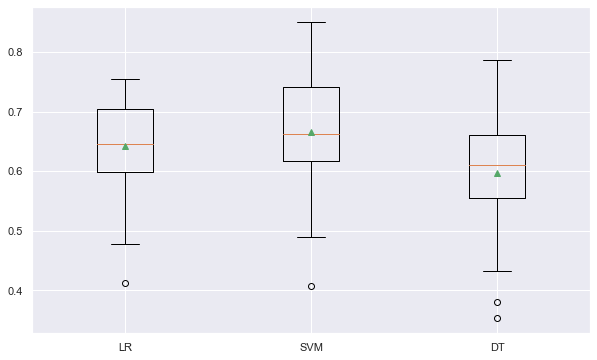

In [40]:
pyplot.figure(figsize=(10,6));
pyplot.boxplot(x= results.values(), labels=results.keys(),
               showmeans=True);

Cost sensitive-methods appear more effective so far

### Ensemble methods


In [41]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, EasyEnsembleClassifier

def get_models():
    models = {}
    models['RF'] = RandomForestClassifier(n_estimators=10)
    models['RF_bal'] = RandomForestClassifier(n_estimators=10, class_weight='balanced')
    models['RF_bal_sub'] = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')
    models['B_RF'] = BalancedRandomForestClassifier(n_estimators=10)
    models['B_BAG'] = BalancedBaggingClassifier(n_estimators=10)
    models['Easy'] = EasyEnsembleClassifier(n_estimators=10)
    return models

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
results = {}
for name, model in get_models().items():
    results[name] = cross_val_score(model, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
    print("Model %s -> Mean F2 score %.3f +/- (%.3f)" % (name, np.mean(results[name]),
                                                        np.std(results[name])
                                                        )
         )
    

Model RF -> Mean F2 score 0.479 +/- (0.105)
Model RF_bal -> Mean F2 score 0.479 +/- (0.110)
Model RF_bal_sub -> Mean F2 score 0.473 +/- (0.110)
Model B_RF -> Mean F2 score 0.690 +/- (0.085)
Model B_BAG -> Mean F2 score 0.654 +/- (0.101)
Model Easy -> Mean F2 score 0.684 +/- (0.082)


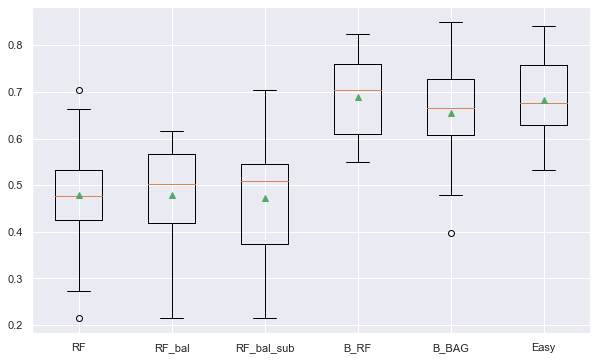

In [42]:
pyplot.figure(figsize=(10,6));
pyplot.boxplot(x= results.values(), labels=results.keys(),
               showmeans=True);

Balanced Ensemble methods seems a good final candidate

### Hyperparam tunning

In [43]:
from sklearn.model_selection import GridSearchCV

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
param_grid = {'n_estimators':[10,100,500,1000]}
model = BalancedRandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    scoring=metric, cv=cv)
grid_result = grid.fit(X_train, y_train)

In [49]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.722641 using {'n_estimators': 100}
0.675500 (0.093022) with: {'n_estimators': 10}
0.722641 (0.073959) with: {'n_estimators': 100}
0.718670 (0.068935) with: {'n_estimators': 500}
0.720226 (0.071143) with: {'n_estimators': 1000}


## Finalize Model 

In [91]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

model = BalancedRandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
final_f2_score = f2_measure(y_true = y_test, y_pred=y_hat)

In [92]:
print("Final model f2_score %.3f" % (final_f2_score))

Final model f2_score 0.660


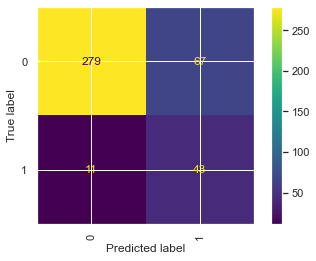

In [102]:
plot_confusion_matrix(model, X_test, y_test, xticks_rotation='vertical')

In [85]:
test = pd.DataFrame(pd.concat([pd.Series(y_test), pd.Series(y_hat)], axis=1))
test.columns = ['real', 'pred']
test.sum()

real     54
pred    107
dtype: int64